# Exploring Data from multiple sources

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from datetime import datetime

### San Bernardino County, CA data points on drought
combined two datasets --> one with observed, monitored drought data and one with replicated, "predicted" drought data. Because the monitored drought data only starts from 2000, we decided to take the "historical" drought data from 1950 to 1999 and concatenate it with the observed dataset.

In [3]:
path = os.getcwd()

new_drought_df = pd.read_csv(path + '/data/SB_DroughtConditions.csv')
# print(new_drought_df.head())

# subset data so that it only includes dates from 2000 - 2024
# print(new_drought_df.dtypes)
new_drought_df = new_drought_df[new_drought_df['MapDate'] >= 20000101]
new_drought_df = new_drought_df[new_drought_df['MapDate'] <= 20241231]
# print(new_drought_df.head())

historical_drought_df = pd.read_csv(path + '/data/SB_historical_drought.csv')
# print(historical_drought_df.head())

# extract needed columns about drought
historical_drought_df = historical_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(historical_drought_df.dtypes)
# splice date string to only include yyyymmdd
historical_drought_df['DATE'] = historical_drought_df['DATE'].str[2:]
# subset data so that it only includes dates from 1950 - 1999
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] >= "19500101"]
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] <= "19991231"]

historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)
# # convert date column to datetime format
# historical_drought_df['date'] = pd.to_datetime(historical_drought_df['date'])
# # format the datetime objects to 'yyyy-mm'
# historical_drought_df['date'] = historical_drought_df['date'].dt.strftime('%Y-%m')
historical_drought_df.reset_index(drop=True, inplace=True)
# print(historical_drought_df.head())

# combine datasets
new_drought_df.rename(columns={'MapDate': 'date'}, inplace=True)
new_drought_df = new_drought_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(new_drought_df.head())

# rename column DATE of historical_drought_df
historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)

# merge datasets
drought_df = pd.concat([historical_drought_df, new_drought_df], axis=0)
print(drought_df.head())

       date    D0    D1    D2    D3    D4
0  19500101  90.1  83.9  57.9  40.8  16.1
1  19500201  92.7  89.4  72.4  50.8  13.1
2  19500301  95.8  90.4  68.8  48.5   8.3
3  19500401  96.1  90.9  70.6  43.6   0.2
4  19500501  97.5  90.8  76.8  29.2   0.1


In [4]:
drought_df.to_csv("SB_drought_labels.csv", index=False)

#### take drought_df with all drought labels and group by month

In [5]:
# convert date column to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])

drought_df = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()
print(drought_df.head())

# format the datetime objects to 'yyyy-mm'
drought_df['date'] = drought_df['date'].dt.strftime('%Y-%m')

# make into csv and store in historical_all
new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "SB_historical_drought_labels.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(drought_df)

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


Accuracy is variable. Goes form 0.74 to 0.9. Should do multiple runs of model? And should make model more robust. Maybe more data.

this is more classification --> change to prediction. Given this time period, predict the next week?

take weather, precipitation, and  --> datasets that give data on future date's climate

Do this after getting data --> causality with DoWhy --> codes up DAG

find the years that may have bad droughts/worst drought conditions

dew point (single value) if we're measuring one day (random day i.e. Jan 1st, 2066)
dew point if we have the previous week --> predict the next week (base off of trend/variability of temp, precip, dew point, humidity)

groundwater data for san bernardino

extract ppt, dp, etc. from tif file (maybe didn't do in the first run? -- find out)

Groundwater data -- combine dates from different well sites to get aggregate groundwater data per unique day.

In [6]:
# Load CSV data
df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])

# 1. Clean data: Ensure numeric values and filter provisional data (optional)
df['parameter_value'] = pd.to_numeric(df['parameter_value'], errors='coerce')
# df = df[df['qualification_cd'] == 'A']  # Uncomment to use only approved data

# 2. Group by date and sum parameter values
daily_totals = df.groupby('datetime', as_index=False).agg({
    'parameter_value': 'sum',
    'agency_cd': 'first'  # Assumes all rows are USGS
})

# 3. Rename columns and handle missing data
daily_totals = daily_totals.rename(columns={
    'parameter_value': 'total_parameter_value'
}).fillna(0)

# 4. Save consolidated data
daily_totals.to_csv("daily_groundwater_totals.csv", index=False)

print(daily_totals.head())

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_69466/1205911318.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])


    datetime  total_parameter_value agency_cd
0 2000-01-01              638157.71      USGS
1 2000-01-02              637681.42      USGS
2 2000-01-03              634953.66      USGS
3 2000-01-04              634403.38      USGS
4 2000-01-05              637111.66      USGS


label droughts by type (flash drought for times when we go from D0 to Dk in a short period of time)

prism data format explanation: https://prism.oregonstate.edu/formats/

### Drought data labels by month

In [7]:
# convert drought_df['DATE'] row to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])
print(drought_df.head())

# group data by month and get most frequent value per month
drought_monthlydf = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()

# drought_monthlydf.columns = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
print(drought_monthlydf.head())


        date    D0    D1    D2    D3    D4
0 1950-01-01  90.1  83.9  57.9  40.8  16.1
1 1950-02-01  92.7  89.4  72.4  50.8  13.1
2 1950-03-01  95.8  90.4  68.8  48.5   8.3
3 1950-04-01  96.1  90.9  70.6  43.6   0.2
4 1950-05-01  97.5  90.8  76.8  29.2   0.1
      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


In [8]:
# convert to csv file
drought_monthlydf.to_csv("SB_monthly_drought_labels.csv", index=False)

### Get 1950-2013 observed historical data from livneh_vic and combine with predicted values from loca_vic HadGEM2-ES with rcp 8.5 to assume worst case baseline for carbon emissions for 2014-2024
different model information: 
1. HadGEM2-ES (warm/dry)
2. CanESM2 (average)
3. CNRM-CM5 (cooler/wetter)
4. MIROC5 the model least like the others to improve coverage of the range of outcomes

Change historical 1950-2013 data from daily to monthly to converge with loca-vic predictive data

In [9]:
# change daily to monthly
daily_airtemp2013 = pd.read_csv(path + '/data/livneh_vic/airtemp_daily.csv')
daily_baseflow2013 = pd.read_csv(path + '/data/livneh_vic/baseflow_daily.csv')
daily_ev2013 = pd.read_csv(path + '/data/livneh_vic/evapotranspiration_daily.csv')
daily_rainfall2013 = pd.read_csv(path + '/data/livneh_vic/rainfall_daily.csv')
daily_runoff2013 = pd.read_csv(path + '/data/livneh_vic/runoff_daily.csv')
daily_snowfall2013 = pd.read_csv(path + '/data/livneh_vic/snowfall_daily.csv')
daily_snowwater2013 = pd.read_csv(path + '/data/livneh_vic/snowwater_daily.csv')
daily_sm2013 = pd.read_csv(path + '/data/livneh_vic/soilmoisture_daily.csv')

dailydf = {"airtemp": daily_airtemp2013, 
           "baseflow": daily_baseflow2013, 
           "ev": daily_ev2013, 
           "rainfall": daily_rainfall2013, 
           "runoff": daily_runoff2013, 
           "snowfall": daily_snowfall2013, 
           "snowwater": daily_snowwater2013,
           "sm": daily_sm2013}

monthly2013_df = {}

for var, df in dailydf.items():
    df['date'] = pd.to_datetime(df['time'])
    column = df.columns[1]
    new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
    new_df.rename(columns={column: var}, inplace=True)
    # print(new_df.head())

    monthly2013_df[f"monthly_{var}2013"] = new_df

monthly_airtemp2013 = monthly2013_df['monthly_airtemp2013']
monthly_baseflow2013 = monthly2013_df['monthly_baseflow2013']
monthly_ev2013 = monthly2013_df['monthly_ev2013']
monthly_rainfall2013 = monthly2013_df['monthly_rainfall2013']
monthly_runoff2013 = monthly2013_df['monthly_runoff2013']
monthly_sm2013 = monthly2013_df['monthly_sm2013']
monthly_snowfall2013 = monthly2013_df['monthly_snowfall2013']
monthly_snowwater2013 = monthly2013_df['monthly_snowwater2013']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_69466/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_69466/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_69466/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_69466/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[colum

load loca-vic data and merge with the 1950-2013 dataa

In [21]:
model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2024_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2014) & (new_df['date'].dt.year <= 2024)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2024_df[f"monthly_{t}2024"] = new_df

monthly_airtemp2024 = monthly2024_df['monthly_airtemp2024']
monthly_baseflow2024 = monthly2024_df['monthly_baseflow2024']
monthly_ev2024 = monthly2024_df['monthly_ev2024']
monthly_rainfall2024 = monthly2024_df['monthly_rainfall2024']
monthly_runoff2024 = monthly2024_df['monthly_runoff2024']
monthly_sm2024 = monthly2024_df['monthly_sm2024']
monthly_snowfall2024 = monthly2024_df['monthly_snowfall2024']
monthly_snowwater2024 = monthly2024_df['monthly_snowwater2024']

In [22]:
# merge with monthly_{var_type}2013

airtemp_df = pd.concat([monthly_airtemp2013, monthly_airtemp2024], axis=0)
baseflow_df = pd.concat([monthly_baseflow2013, monthly_baseflow2024], axis=0)
ev_df = pd.concat([monthly_ev2013, monthly_ev2024], axis=0)
rainfall_df = pd.concat([monthly_rainfall2013, monthly_rainfall2024], axis=0)
runoff_df = pd.concat([monthly_runoff2013, monthly_runoff2024], axis=0)
sm_df = pd.concat([monthly_sm2013, monthly_sm2024], axis=0)
snowfall_df = pd.concat([monthly_snowfall2013, monthly_snowfall2024], axis=0)
snowwater_df = pd.concat([monthly_snowwater2013, monthly_snowwater2024], axis=0)

print(airtemp_df.head())
print(baseflow_df.head())
print(ev_df.head())
print(rainfall_df.head())
print(runoff_df.head())
print(sm_df.head())
print(snowfall_df.head())
print(snowwater_df.head())

# new_dir = path + '/data/historical_all'
# os.makedirs(new_dir, exist_ok=True)

# # make all df into csv files in new directory
# new_filepath = os.path.join(new_dir, "airtemp.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(airtemp_df)

# new_filepath = os.path.join(new_dir, "baseflow.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(baseflow_df)

# new_filepath = os.path.join(new_dir, "ev.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(ev_df)

# new_filepath = os.path.join(new_dir, "rainfall.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(rainfall_df)

# new_filepath = os.path.join(new_dir, "runoff.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(runoff_df)

# new_filepath = os.path.join(new_dir, "sm.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(sm_df)

# new_filepath = os.path.join(new_dir, "snowfall.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(snowfall_df)

# new_filepath = os.path.join(new_dir, "snowwater.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(snowwater_df)

      date    airtemp
0  1950-01   5.469246
1  1950-02  11.261756
2  1950-03  13.522296
3  1950-04  18.837398
4  1950-05  20.676498
      date  baseflow
0  1950-01  0.036113
1  1950-02  0.036952
2  1950-03  0.033402
3  1950-04  0.039273
4  1950-05  0.029522
      date        ev
0  1950-01  0.712696
1  1950-02  0.947727
2  1950-03  0.763165
3  1950-04  0.317350
4  1950-05  0.155867
      date  rainfall
0  1950-01  0.207599
1  1950-02  0.446101
2  1950-03  0.412884
3  1950-04  0.112882
4  1950-05  0.021634
      date    runoff
0  1950-01  0.011982
1  1950-02  0.028984
2  1950-03  0.010870
3  1950-04  0.007152
4  1950-05  0.000562
      date         sm
0  1950-01  11.695956
1  1950-02   9.503363
2  1950-03   7.893302
3  1950-04   6.434203
4  1950-05   5.557502
      date  snowfall
0  1950-01  0.139311
1  1950-02  0.023380
2  1950-03  0.025884
3  1950-04  0.027177
4  1950-05  0.002887
      date  snowwater
0  1950-01   0.707678
1  1950-02   0.467992
2  1950-03   0.215861
3  1950-04   0.110

Merge drought levels data with variable data

In [31]:
from functools import reduce

# merge all variables together into dataframe
dfs = [airtemp_df, baseflow_df, ev_df, rainfall_df, runoff_df, sm_df, snowfall_df, snowwater_df]
historical_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(historical_all_df.head())

# new_filepath = os.path.join(new_dir, "all_historical.csv")
# with open(new_filepath, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerows(historical_all_df)

      date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0  1950-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1  1950-02  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2  1950-03  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3  1950-04  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4  1950-05  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater  
0  0.139311   0.707678  
1  0.023380   0.467992  
2  0.025884   0.215861  
3  0.027177   0.110780  
4  0.002887   0.026390  


In [26]:
print(drought_df.head())

drought_df['date'] = pd.to_datetime(drought_df['date'], format='%Y-%m')
historical_all_df['date'] = pd.to_datetime(historical_all_df['date'], format='%Y-%m')

# merge historical_all_df with drought_df
final_historical_df = pd.merge(historical_all_df, drought_df, on='date', how='inner')
print(final_historical_df.head())

        date    D0    D1    D2    D3    D4
0 1950-01-01  90.1  83.9  57.9  40.8  16.1
1 1950-02-01  92.7  89.4  72.4  50.8  13.1
2 1950-03-01  95.8  90.4  68.8  48.5   8.3
3 1950-04-01  96.1  90.9  70.6  43.6   0.2
4 1950-05-01  97.5  90.8  76.8  29.2   0.1
        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0 1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1 1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2 1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3 1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4 1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater    D0    D1    D2    D3    D4  
0  0.139311   0.707678  90.1  83.9  57.9  40.8  16.1  
1  0.023380   0.467992  92.7  89.4  72.4  50.8  13.1  
2  0.025884   0.215861  95.8  90.4  68.8  48.5   8.3  
3  0.027177   0.110780  96.1  90.9  70.6  43.6   0.2 

In [32]:
final_historical_df.to_csv("final_historical.csv")

## 1950-2013
Merge 1950-2013 variable data with drought data only until **2013**

In [52]:
cv_historical_df = final_historical_df.copy()

cv_historical_df['date'] = cv_historical_df['date'].apply(
    lambda x: x.to_timestamp() if isinstance(x, pd.Period) else pd.to_datetime(x)
)

cv_historical_df = cv_historical_df[cv_historical_df['date'].dt.year < 2014]

print(cv_historical_df)

          date    airtemp  baseflow        ev  rainfall    runoff         sm  \
18  1951-07-01  29.606585  0.024184  0.259252  0.347470  0.004031   6.257998   
19  1951-08-01  27.552820  0.023845  0.356020  0.559407  0.009121   7.100352   
20  1951-09-01  25.942159  0.023688  0.347001  0.256850  0.003758   6.671861   
21  1951-10-01  18.153869  0.023507  0.304141  0.338916  0.005134   7.103659   
22  1951-11-01  11.031221  0.023500  0.264308  0.333856  0.007990   8.814890   
..         ...        ...       ...       ...       ...       ...        ...   
763 2013-08-01  28.717042  0.026354  0.347947  0.561113  0.008274   6.916853   
764 2013-09-01  25.199694  0.026135  0.523672  0.312458  0.004821   8.541084   
765 2013-10-01  17.191673  0.025938  0.080414  0.072593  0.001138   5.760195   
766 2013-11-01  12.775977  0.025719  0.278565  0.710123  0.015111   8.983794   
767 2013-12-01   8.067449  0.025587  0.264997  0.076278  0.001941  11.967273   

         snowfall  snowwater        D0 

## LSTM

Only do for D0-D3. Only classification for D4

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2178 - mae: 0.3238 - val_loss: 0.0700 - val_mae: 0.1995
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0538 - mae: 0.1614 - val_loss: 0.0482 - val_mae: 0.1599
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384 - mae: 0.1273 - val_loss: 0.0524 - val_mae: 0.1577
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 - mae: 0.1267 - val_loss: 0.0518 - val_mae: 0.1626
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - mae: 0.1257 - val_loss: 0.0765 - val_mae: 0.1877
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0405 - mae: 0.1227 - val_loss: 0.0462 - val_mae: 0.1569
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0365 - mae: 0.1187 - val_loss: 0.0543 - val_mae: 0.1583
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0326 - mae: 0.1086 - val_loss: 0.0566 - val_mae: 0.1628
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0387 - mae: 0

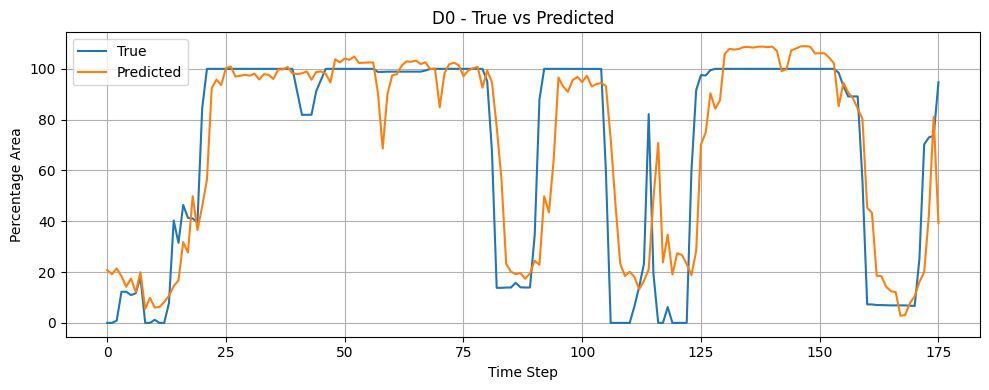

D1 - MAE: 12.3327, R²: 0.8174


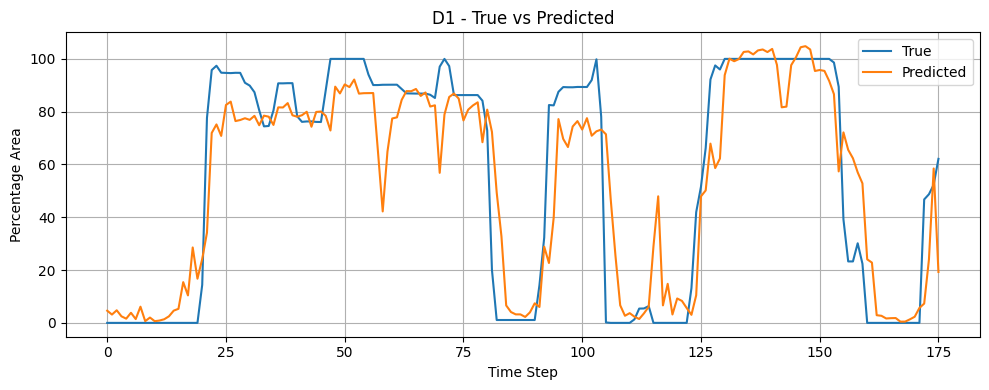

D2 - MAE: 16.6746, R²: 0.6396


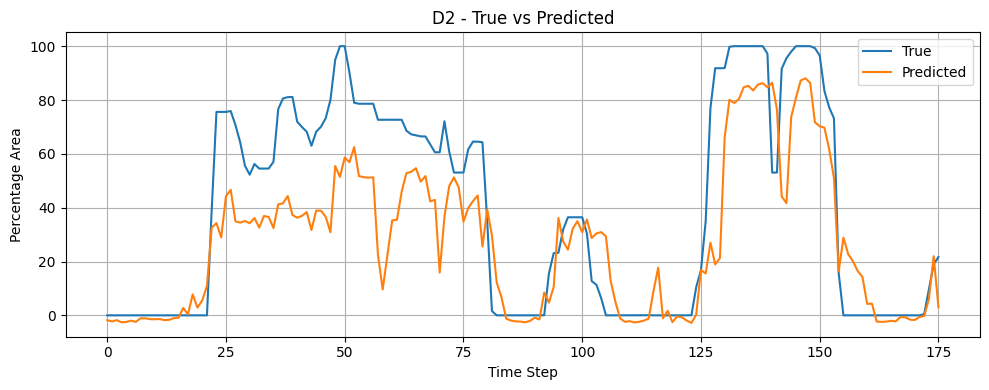

D3 - MAE: 11.7115, R²: 0.4665


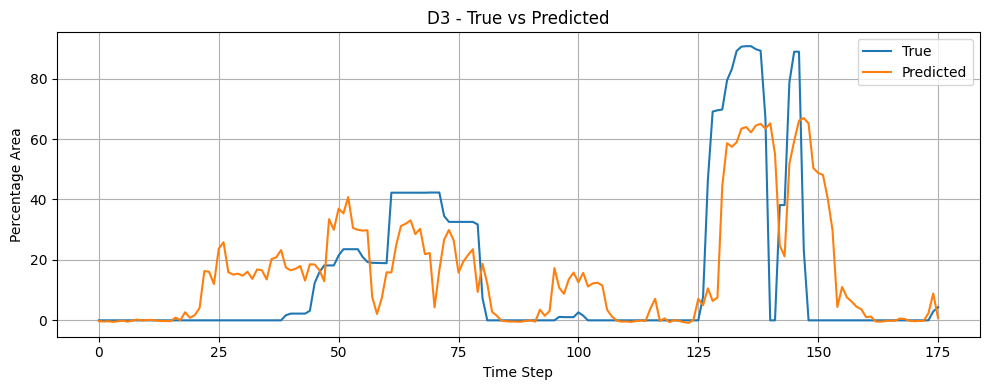

D4 - MAE: 4.5152, R²: -1.1912


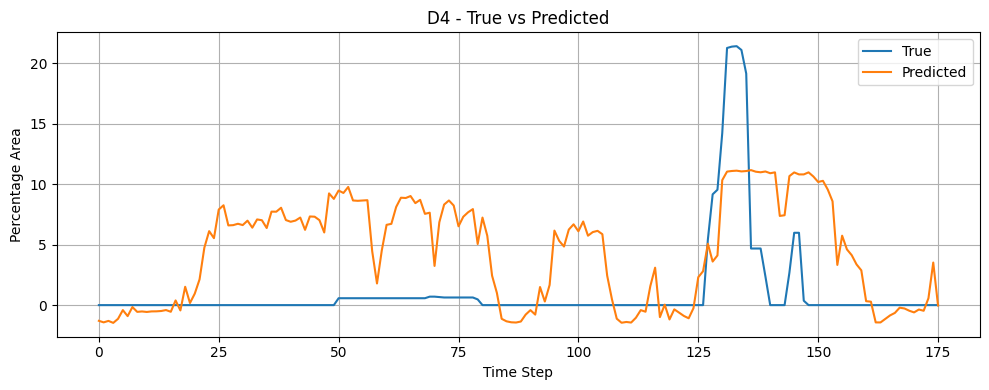

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Step 1: Preprocessing and Feature Engineering
# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Step 2: Prepare Features and Targets
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize Features and Targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Step 3: Create Sequences for LSTM
SEQ_LENGTH = 12 # 12 time steps (e.g., 12 weeks of data)
# 12 = all r^2 are above 0 (d3,4 improved)

X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 4: Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches D0, D1, D2, D3, D4
])

learning_rate = 0.05
# Compile the model with the custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 6: Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for each drought level
from sklearn.metrics import mean_absolute_error, r2_score

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    r2 = r2_score(y_test_orig[:, i], y_pred[:, i])
    print(f"{category} - MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig[:, i], label='True')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{category} - True vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Area")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Random Forest and XgBoost


====== RandomForest Results ======
D0 - MAE: 9.0710, R²: 0.8448


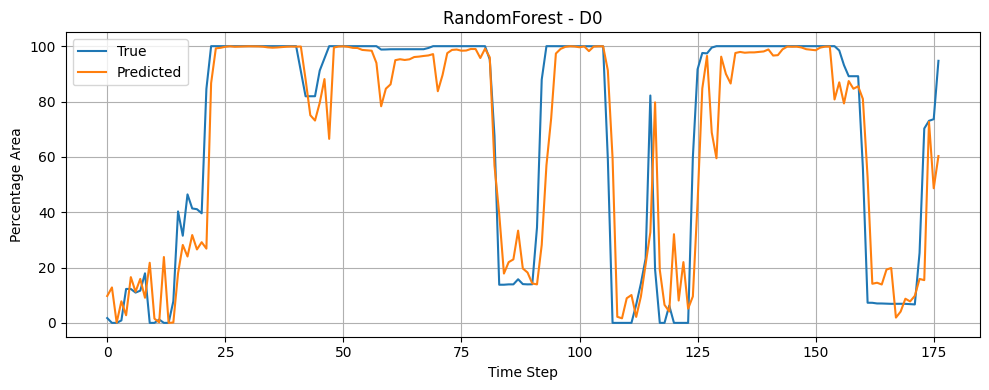

D1 - MAE: 8.5787, R²: 0.8861


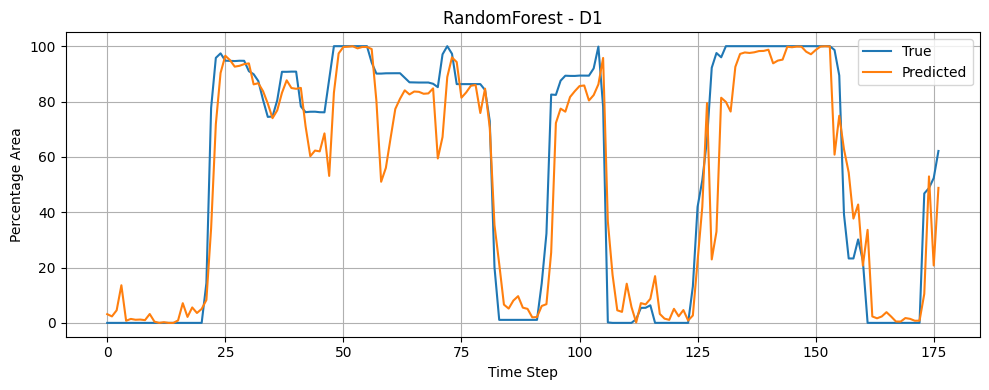

D2 - MAE: 11.5091, R²: 0.8002


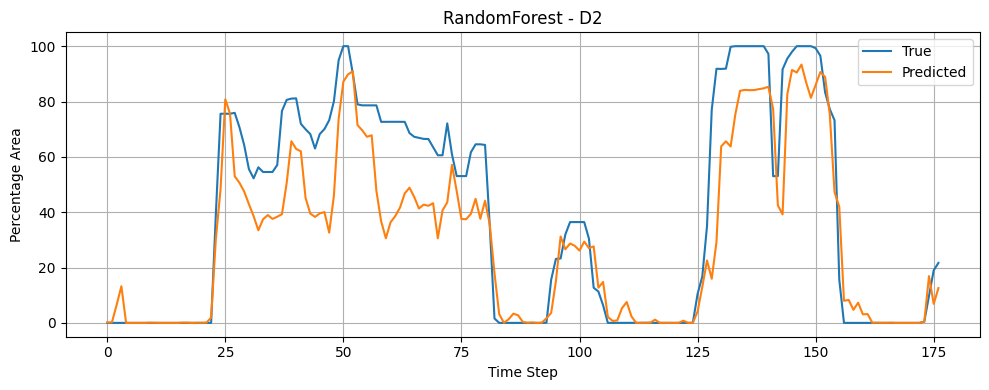

D3 - MAE: 7.1130, R²: 0.7141


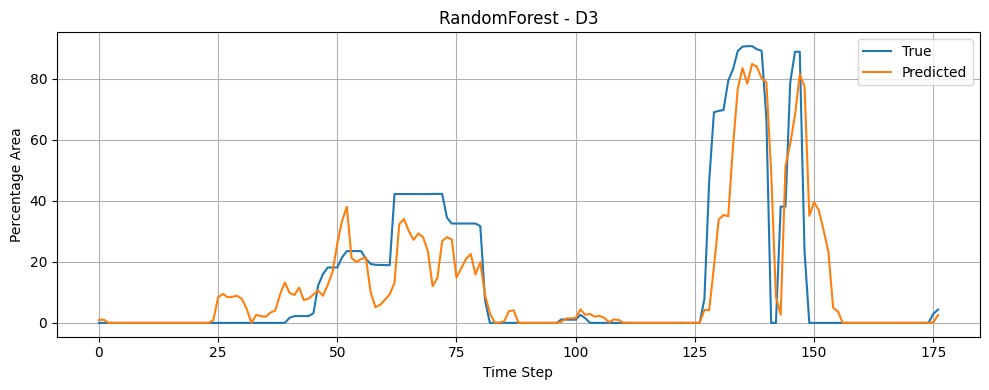

D4 - MAE: 0.8298, R²: 0.5098


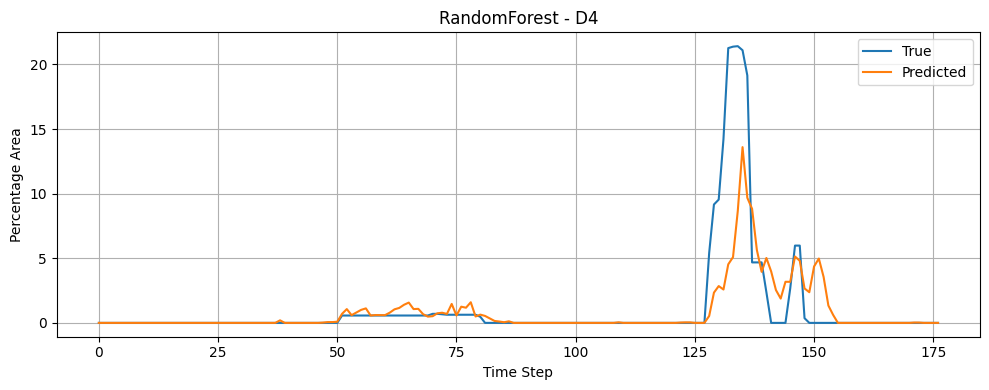


====== XGBoost Results ======
D0 - MAE: 9.9720, R²: 0.8279


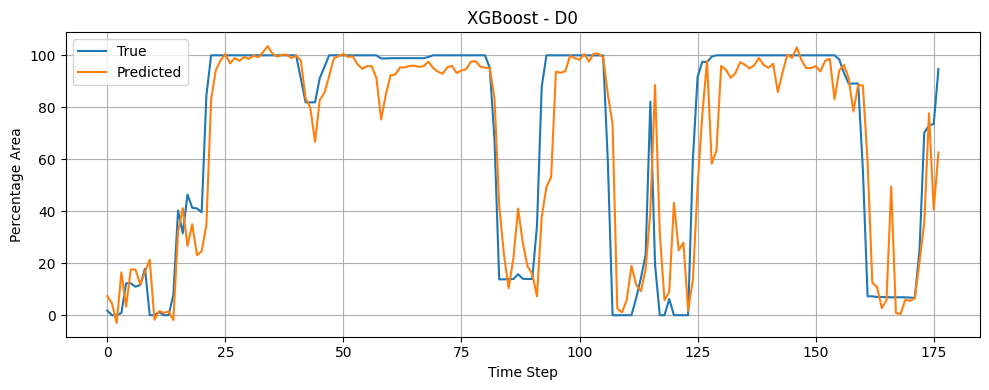

D1 - MAE: 9.0551, R²: 0.8752


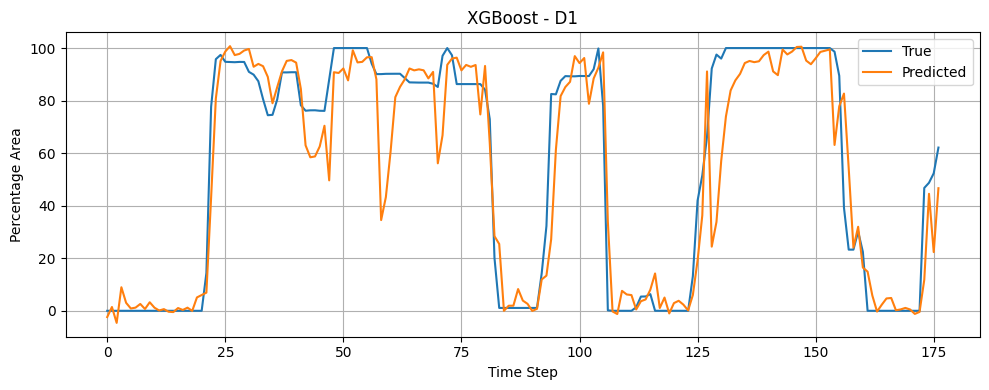

D2 - MAE: 13.3324, R²: 0.6995


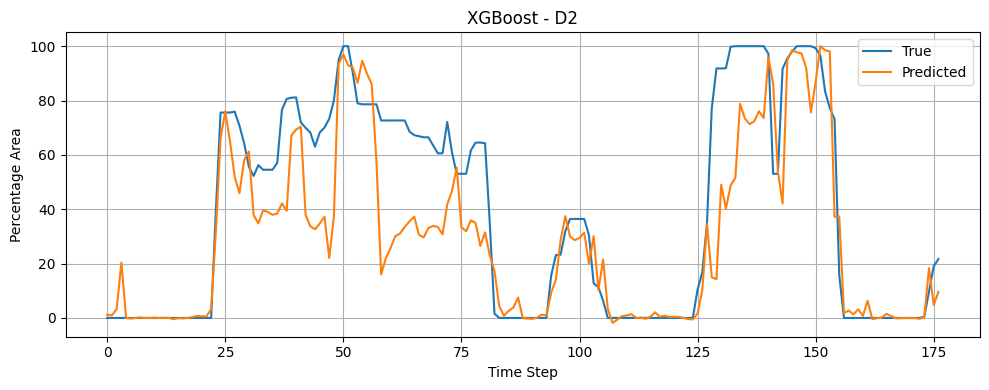

D3 - MAE: 7.9012, R²: 0.6019


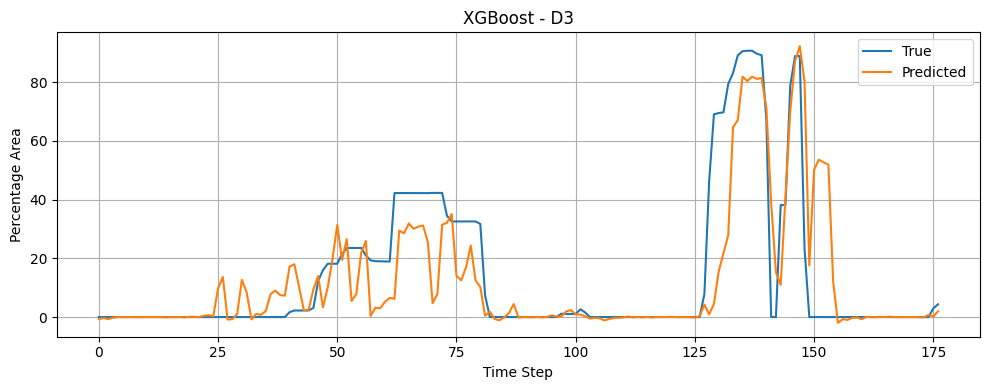

D4 - MAE: 1.0644, R²: 0.0968


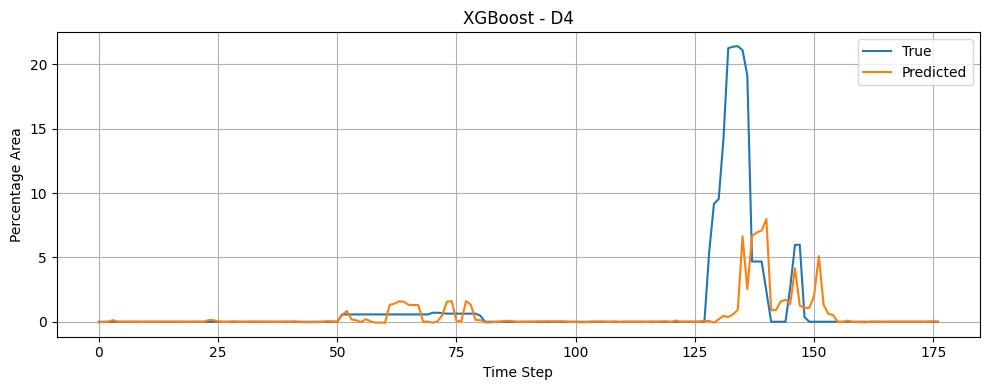

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Feature Engineering
df = final_historical_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Create lag features
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Create rolling stats (7-day window)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    df[f'{col}_roll_mean'] = df[col].rolling(window=7).mean()
    df[f'{col}_roll_std'] = df[col].rolling(window=7).std()

# Drop NaNs caused by lag and rolling
df = df.dropna().reset_index(drop=True)

# Step 2: Features and Targets
X = df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
y = df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx].values, y[split_idx:].values

# Step 3: Fit and Evaluate Models
results = {}

for model_name, model_class in {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor
}.items():
    
    print(f"\n====== {model_name} Results ======")
    model_results = {}
    
    for i, target in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
        model = model_class(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[:, i], y_pred)
        r2 = r2_score(y_test[:, i], y_pred)
        model_results[target] = {'MAE': mae, 'R2': r2}
        
        print(f"{target} - MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Plot predictions
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:, i], label='True')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"{model_name} - {target}")
        plt.xlabel("Time Step")
        plt.ylabel("Percentage Area")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    results[model_name] = model_results



--- D0 ---

RandomForest:
MAE: 9.5879, R^2: 0.8418


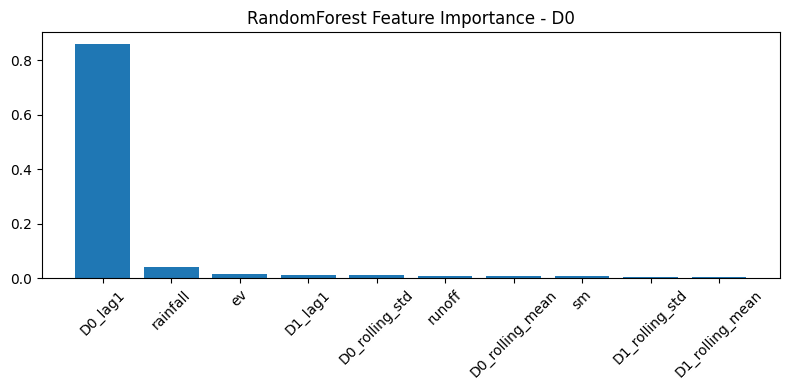


XGBoost:
MAE: 10.4356, R^2: 0.8353


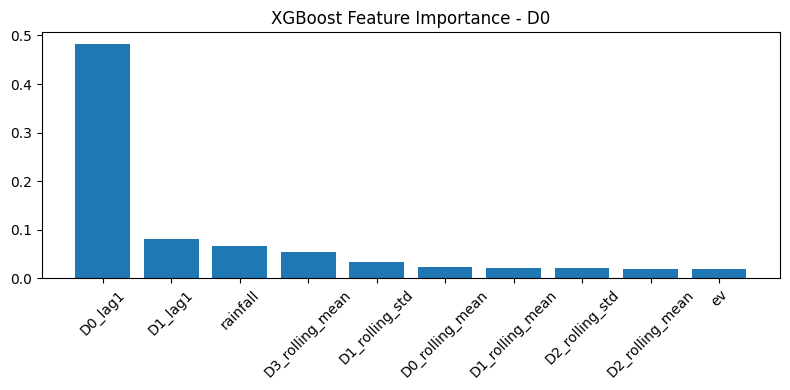


--- D1 ---

RandomForest:
MAE: 8.3820, R^2: 0.8868


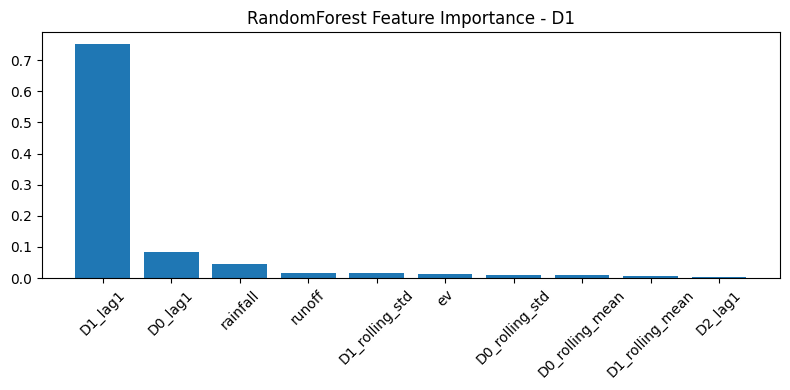


XGBoost:
MAE: 8.8568, R^2: 0.8775


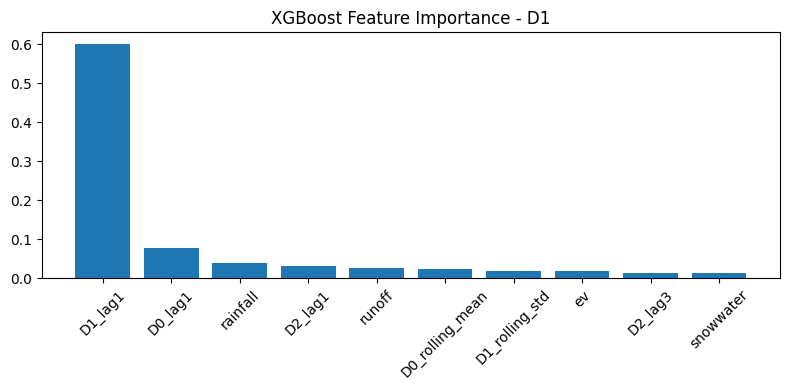


--- D2 ---

RandomForest:
MAE: 12.6959, R^2: 0.7490


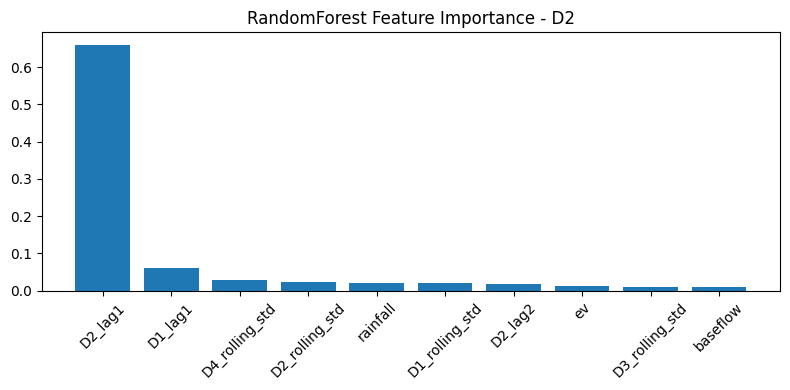


XGBoost:
MAE: 12.0936, R^2: 0.7629


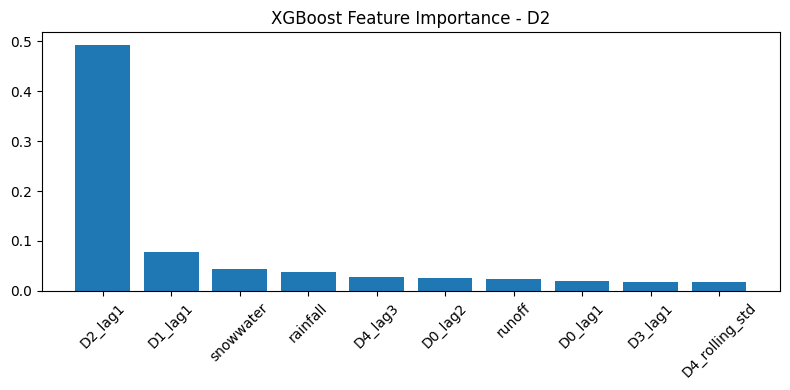


--- D3 ---

RandomForest:
MAE: 7.1595, R^2: 0.7074


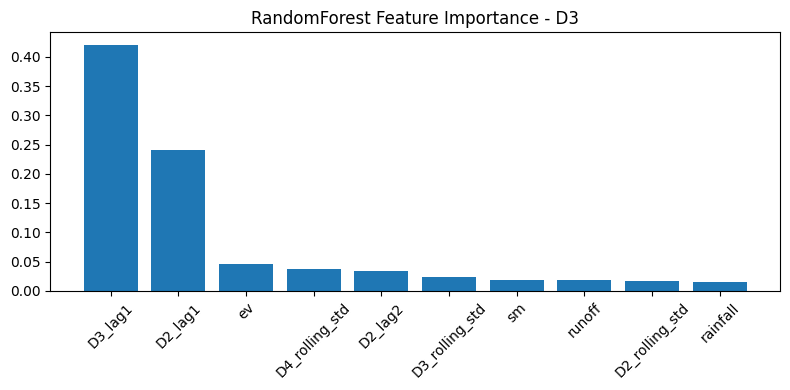


XGBoost:
MAE: 7.4490, R^2: 0.6117


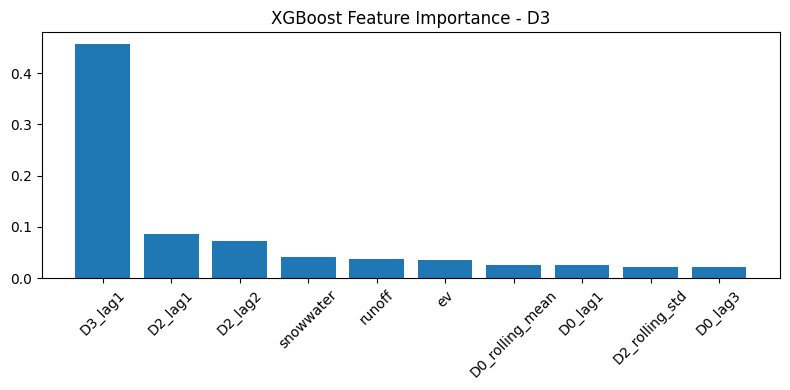


--- D4 ---

RandomForest:
MAE: 0.7998, R^2: 0.5708


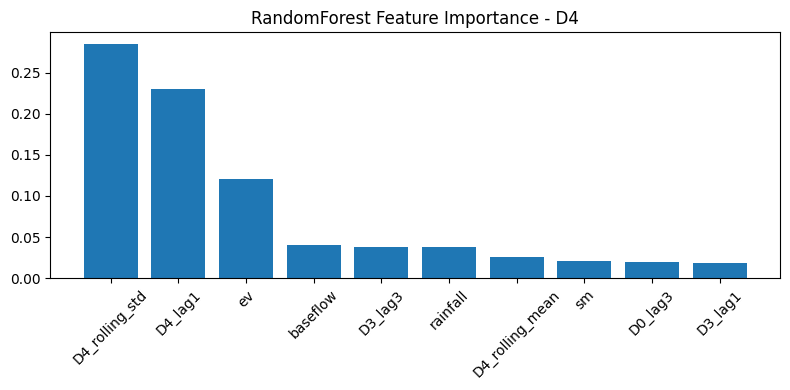


XGBoost:
MAE: 0.9785, R^2: 0.0957


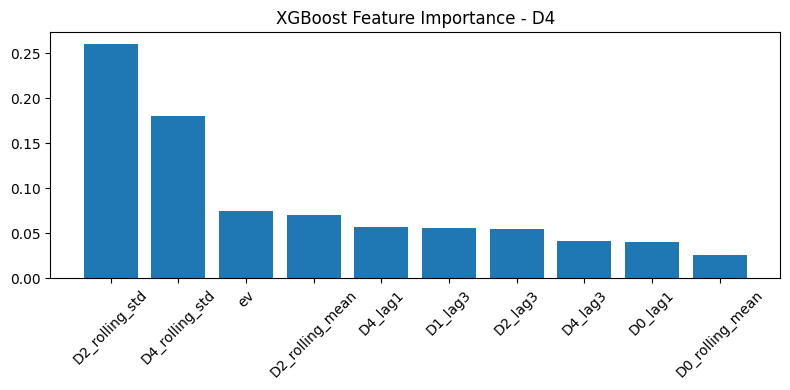

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1097 - mae: 0.2058 - val_loss: 0.1678 - val_mae: 0.3207
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0582 - mae: 0.1713 - val_loss: 0.1551 - val_mae: 0.2935
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0577 - mae: 0.1623 - val_loss: 0.1254 - val_mae: 0.2524
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0489 - mae: 0.1520 - val_loss: 0.1155 - val_mae: 0.2424
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485 - mae: 0.1466 - val_loss: 0.1026 - val_mae: 0.2273
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0455 - mae: 0.1375 - val_loss: 0.0986 - val_mae: 0.2284
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0410 - mae: 0.1332 - val_loss: 0.0947 - val_mae: 0.2225
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0352 - mae: 0.1214 - val_loss: 0.0847 - val_mae: 0.2259
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0339 - mae: 

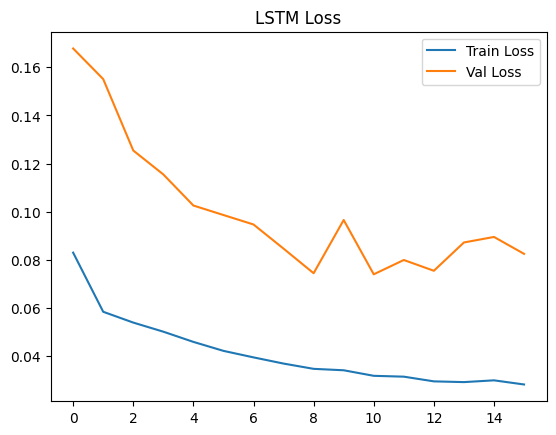

In [34]:
# Full pipeline: Drought prediction using Random Forest, XGBoost, LSTM (with tuning) and LightGBM per drought level

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------- Data Preprocessing ----------
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create lag features and rolling stats
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

final_historical_df = final_historical_df.dropna()

# Feature/target split
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
targets = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    features, targets, test_size=0.2, shuffle=False
)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# ---------- Random Forest & XGBoost (with Grid Search & Feature Importance) ----------
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 6]
    }
}

tscv = TimeSeriesSplit(n_splits=3)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_train = y_train_full[drought_level]
    y_test = y_test_full[drought_level]

    for name, model in models.items():
        print(f"\n{name}:")
        gsearch = GridSearchCV(model, param_grids[name], cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        gsearch.fit(X_train_scaled, y_train)
        best_model = gsearch.best_estimator_

        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"MAE: {mae:.4f}, R^2: {r2:.4f}")

        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(8, 4))
        plt.bar(np.array(features.columns)[sorted_idx], importances[sorted_idx])
        plt.title(f'{name} Feature Importance - {drought_level}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# ---------- LSTM (with Feature Selection if Desired) ----------
# We use the same preprocessing from before to create sequences
SEQ_LENGTH = 12
X_seq, y_seq = [], []

# Multivariate output for LSTM
scaled_targets = MinMaxScaler().fit_transform(y_train_full)

for i in range(len(X_train_scaled) - SEQ_LENGTH):
    X_seq.append(X_train_scaled[i:i+SEQ_LENGTH])
    y_seq.append(scaled_targets[i+SEQ_LENGTH])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train_lstm, X_val_lstm = X_seq[:-100], X_seq[-100:]
y_train_lstm, y_val_lstm = y_seq[:-100], y_seq[-100:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()
plt.show()


## Cross Validation for all models

In [53]:
print(cv_historical_df)

          date    airtemp  baseflow        ev  rainfall    runoff         sm  \
18  1951-07-01  29.606585  0.024184  0.259252  0.347470  0.004031   6.257998   
19  1951-08-01  27.552820  0.023845  0.356020  0.559407  0.009121   7.100352   
20  1951-09-01  25.942159  0.023688  0.347001  0.256850  0.003758   6.671861   
21  1951-10-01  18.153869  0.023507  0.304141  0.338916  0.005134   7.103659   
22  1951-11-01  11.031221  0.023500  0.264308  0.333856  0.007990   8.814890   
..         ...        ...       ...       ...       ...       ...        ...   
763 2013-08-01  28.717042  0.026354  0.347947  0.561113  0.008274   6.916853   
764 2013-09-01  25.199694  0.026135  0.523672  0.312458  0.004821   8.541084   
765 2013-10-01  17.191673  0.025938  0.080414  0.072593  0.001138   5.760195   
766 2013-11-01  12.775977  0.025719  0.278565  0.710123  0.015111   8.983794   
767 2013-12-01   8.067449  0.025587  0.264997  0.076278  0.001941  11.967273   

         snowfall  snowwater        D0 


--- D0 ---

Random Forest - D0 - Cross-Validation Results:
R² Mean: 0.8466, Std: 0.0226
MSE Mean: 0.0242, Std: -0.0033
MAE Mean: 0.0968, Std: -0.0067


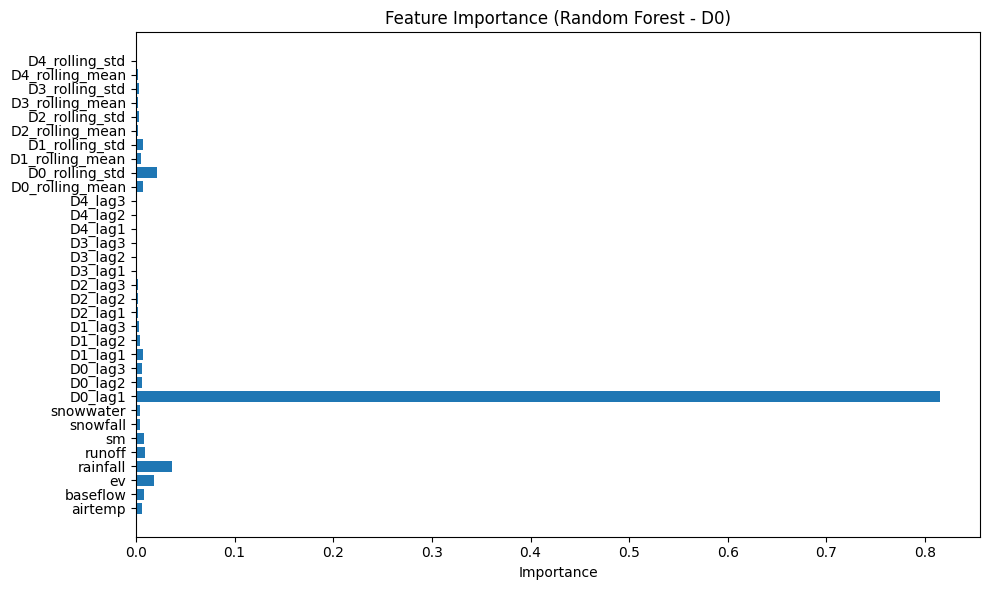


--- D1 ---

Random Forest - D1 - Cross-Validation Results:
R² Mean: 0.8426, Std: 0.0440
MSE Mean: 0.0207, Std: -0.0065
MAE Mean: 0.0871, Std: -0.0109


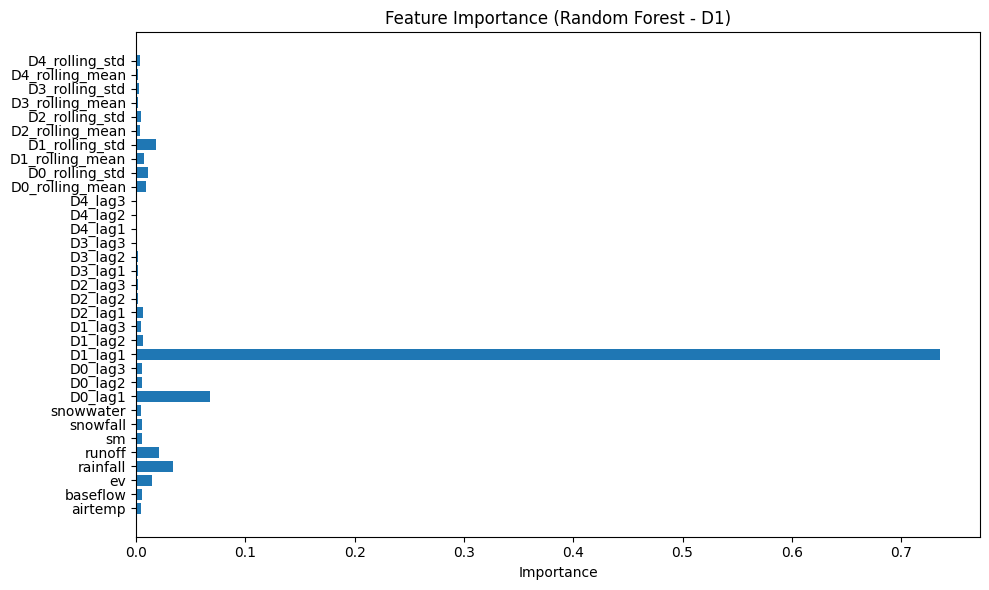


--- D2 ---

Random Forest - D2 - Cross-Validation Results:
R² Mean: 0.8228, Std: 0.0414
MSE Mean: 0.0123, Std: -0.0045
MAE Mean: 0.0569, Std: -0.0089


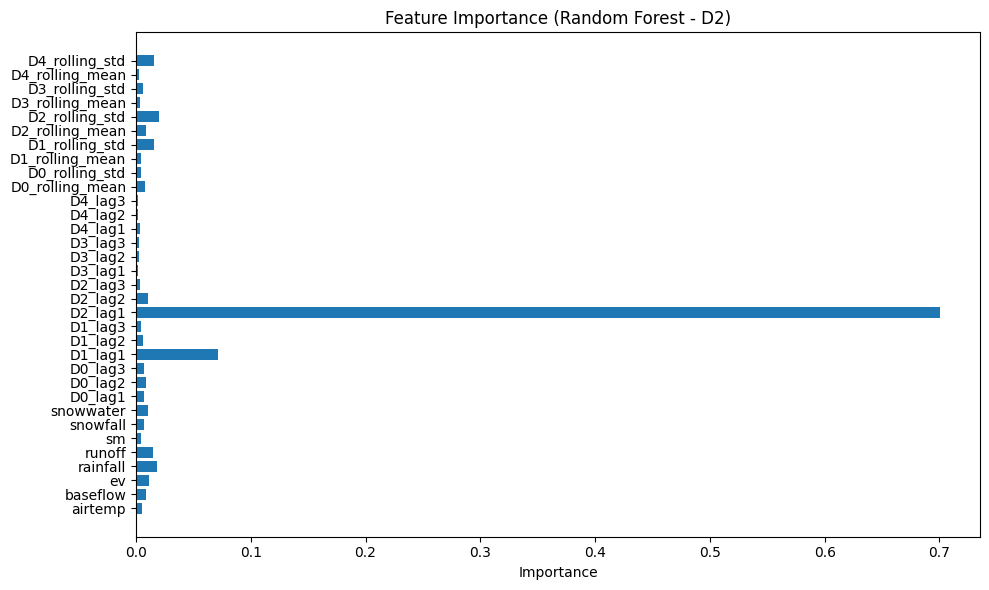


--- D3 ---

Random Forest - D3 - Cross-Validation Results:
R² Mean: 0.7332, Std: 0.1424
MSE Mean: 0.0095, Std: -0.0054
MAE Mean: 0.0392, Std: -0.0119


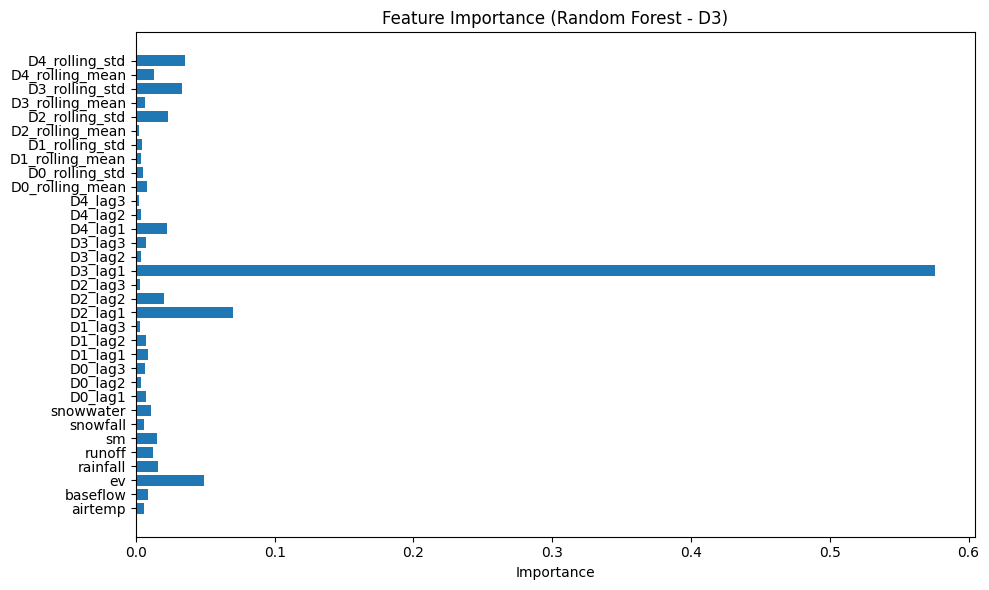


--- D4 ---

Random Forest - D4 - Cross-Validation Results:
R² Mean: 0.3684, Std: 0.3067
MSE Mean: 0.0070, Std: -0.0046
MAE Mean: 0.0246, Std: -0.0097


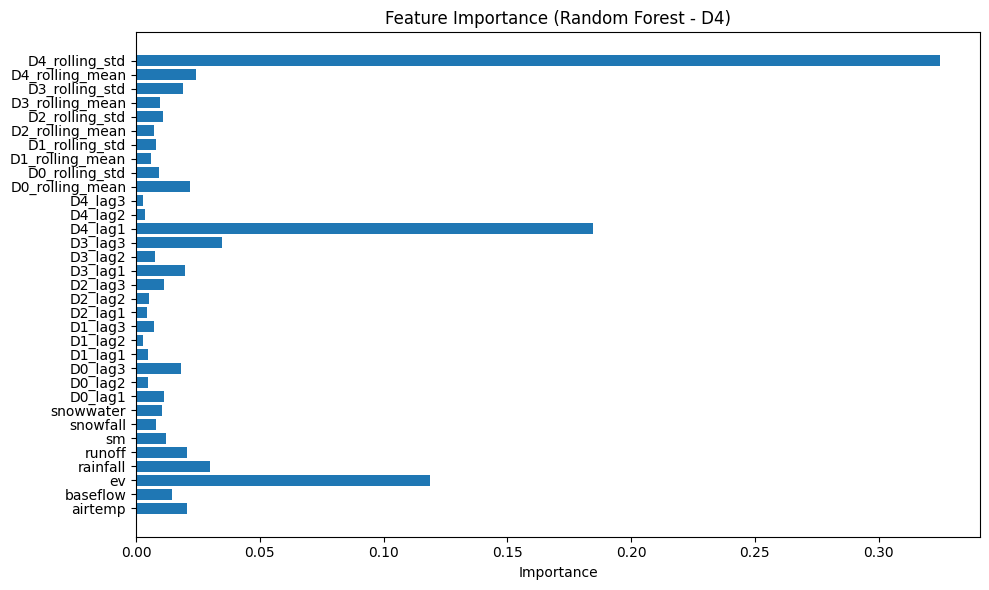


--- D0 ---

XGBoost - D0 - Cross-Validation Results:
R² Mean: 0.8428, Std: 0.0319
MSE Mean: 0.0247, Std: -0.0045
MAE Mean: 0.0995, Std: -0.0111


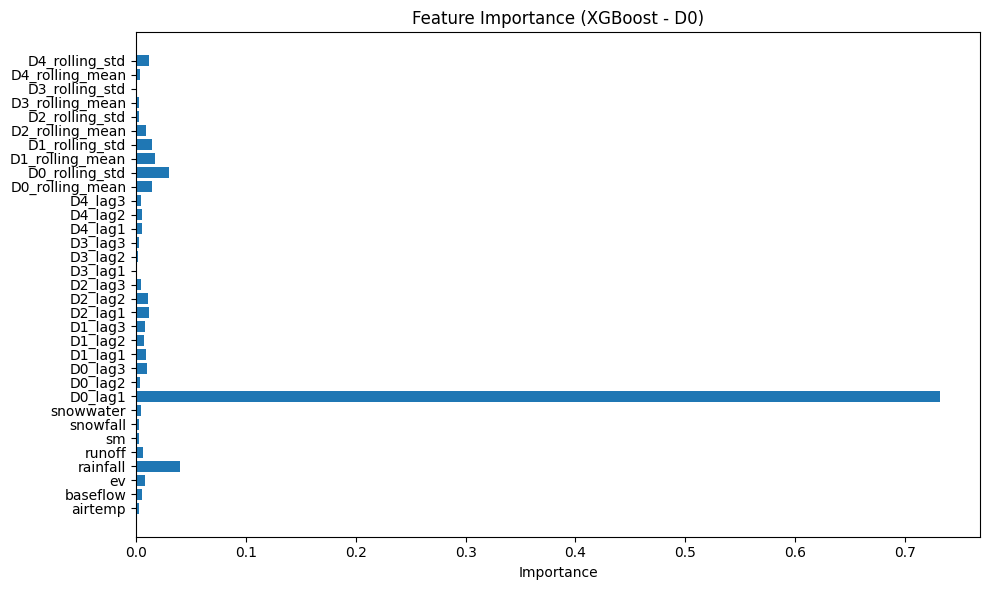


--- D1 ---

XGBoost - D1 - Cross-Validation Results:
R² Mean: 0.8435, Std: 0.0336
MSE Mean: 0.0207, Std: -0.0053
MAE Mean: 0.0875, Std: -0.0069


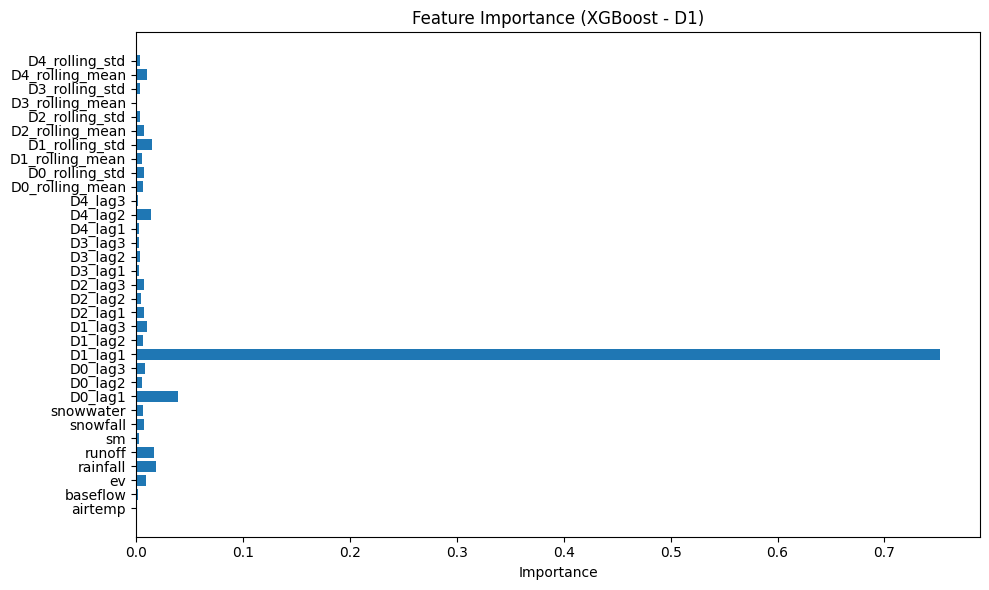


--- D2 ---

XGBoost - D2 - Cross-Validation Results:
R² Mean: 0.7981, Std: 0.0299
MSE Mean: 0.0138, Std: -0.0033
MAE Mean: 0.0604, Std: -0.0077


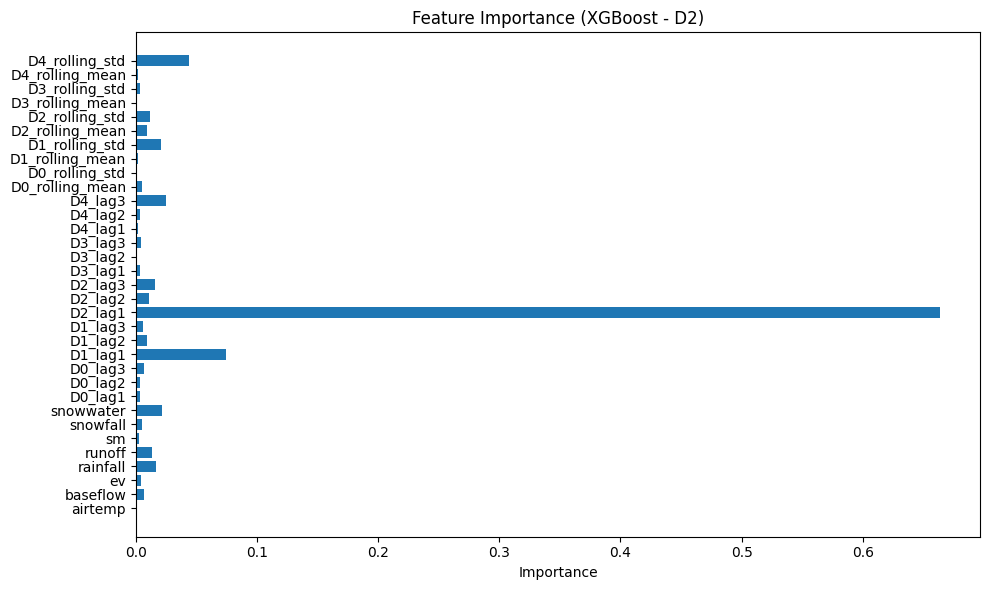


--- D3 ---

XGBoost - D3 - Cross-Validation Results:
R² Mean: 0.6855, Std: 0.1252
MSE Mean: 0.0111, Std: -0.0046
MAE Mean: 0.0423, Std: -0.0105


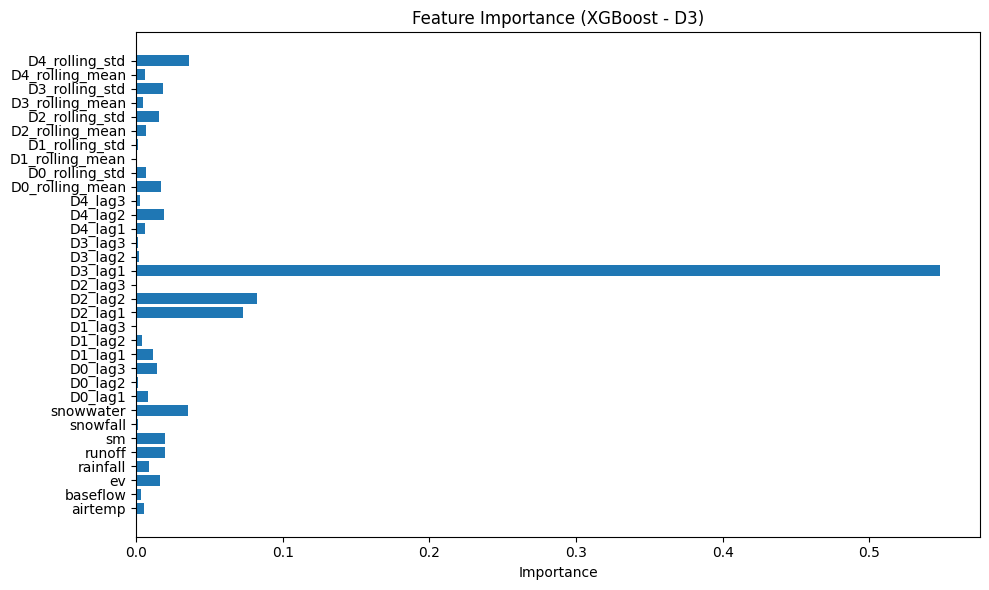


--- D4 ---

XGBoost - D4 - Cross-Validation Results:
R² Mean: 0.3178, Std: 0.3529
MSE Mean: 0.0071, Std: -0.0043
MAE Mean: 0.0230, Std: -0.0097


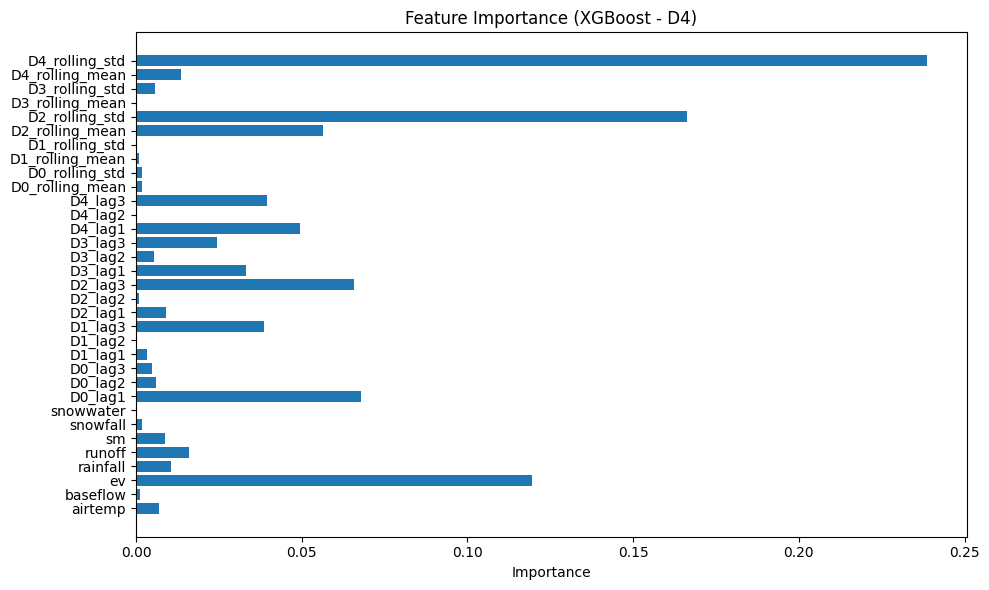


--- D0 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5240
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] Start training from score 0.413189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


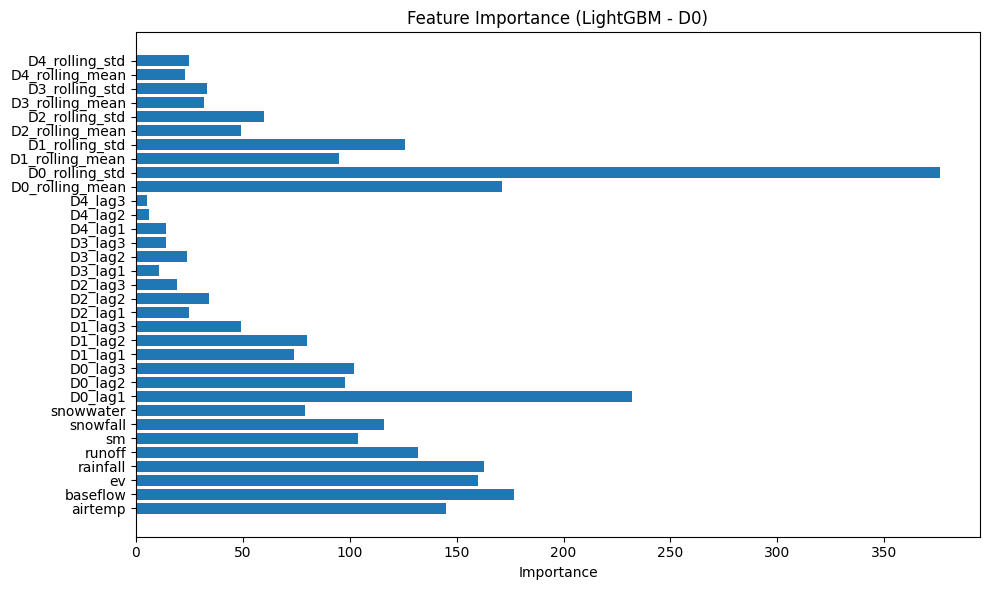


--- D1 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5240
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] Start training from score 0.296094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


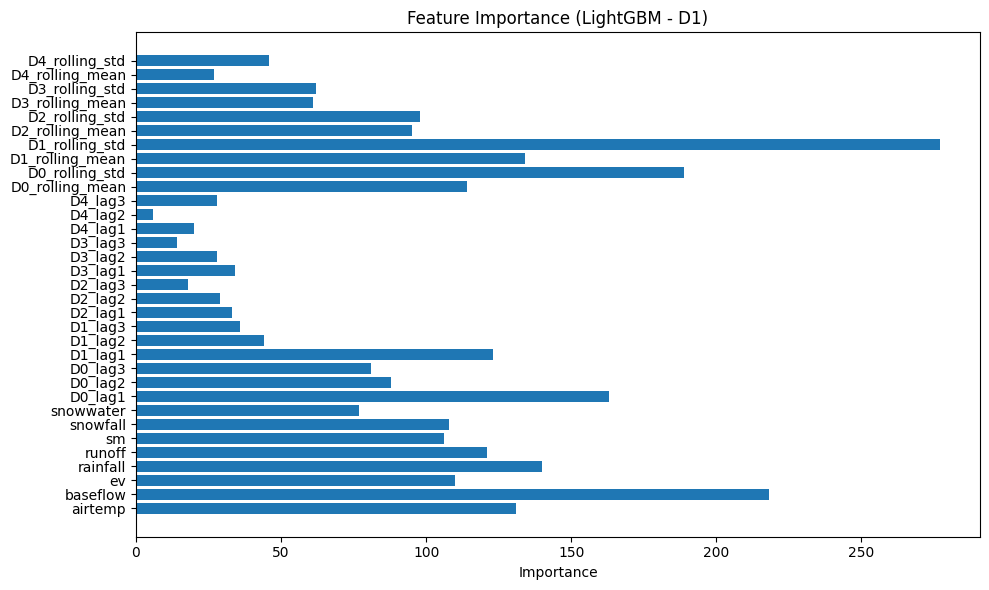


--- D2 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5240
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] Start training from score 0.147430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x1312fbd80>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


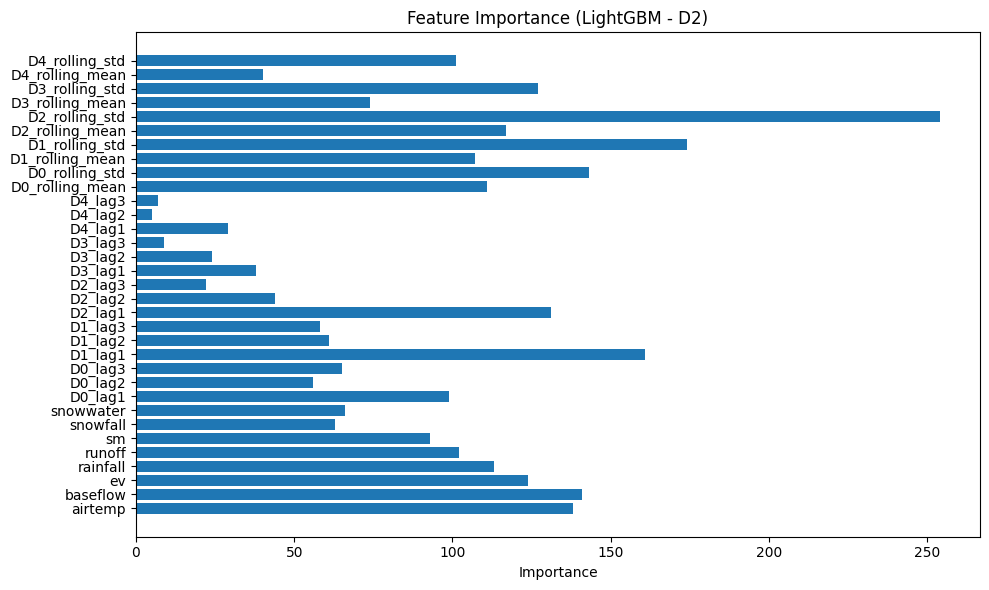


--- D3 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5240
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] Start training from score 0.070410
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4170
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 33
[LightGBM] [Info] Start training from score 0.075849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4137
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 33
[LightGBM] [Info] Start training from score 0.063426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4185
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 33
[LightGBM] [Info] Start training from score 0.071670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


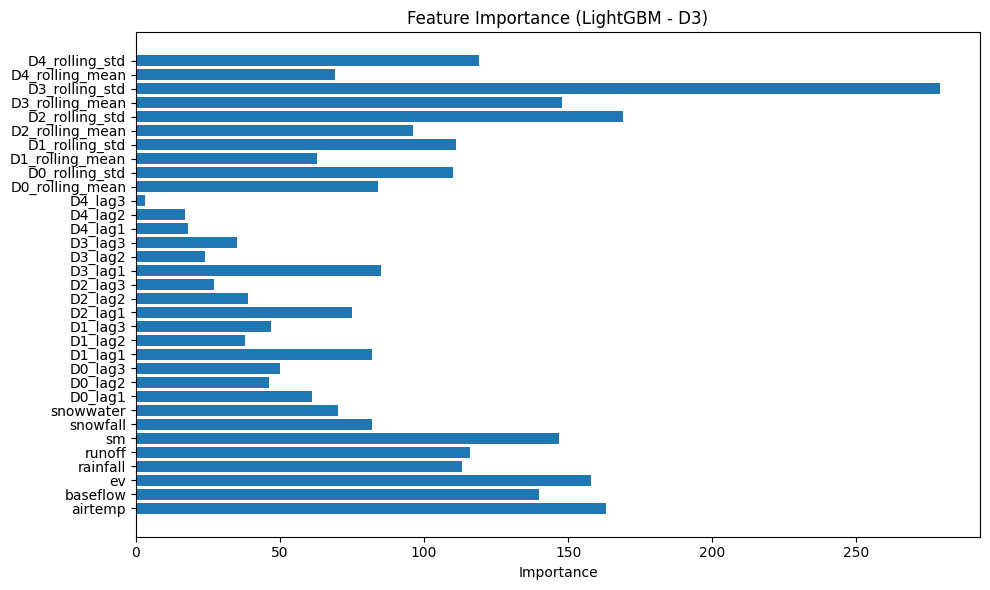


--- D4 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5240
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] Start training from score 0.025300
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming final_historical_df is already preprocessed and contains features like lag and rolling stats

# Prepare the features and target variables
features = cv_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = cv_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize the features and targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Convert y_scaled to a DataFrame for easier indexing by column names
y_scaled_df = pd.DataFrame(y_scaled, columns=['D0', 'D1', 'D2', 'D3', 'D4'])

# Function to evaluate and print metrics for each model
def evaluate_model(model, X, y, label='Model'):
    # Train the model before evaluating
    model.fit(X, y)
    
    # Perform cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    scores_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')

    print(f"\n{label} - Cross-Validation Results:")
    print(f"R² Mean: {scores_r2.mean():.4f}, Std: {scores_r2.std():.4f}")
    print(f"MSE Mean: {-scores_mse.mean():.4f}, Std: {-scores_mse.std():.4f}")
    print(f"MAE Mean: {-scores_mae.mean():.4f}, Std: {-scores_mae.std():.4f}")

    # Plot feature importances (for Random Forest, XGBoost, LightGBM)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'get_booster'):
        feature_importances = model.get_booster().get_score(importance_type='weight')
    else:
        feature_importances = None
    
    if feature_importances is not None:
        plt.figure(figsize=(10, 6))
        if isinstance(feature_importances, np.ndarray):  # For Random Forest
            plt.barh(range(len(feature_importances)), feature_importances)
            plt.yticks(range(len(feature_importances)), features.columns)
        else:  # For XGBoost or LightGBM
            importance_scores = [feature_importances.get(f"f{i}", 0) for i in range(len(features.columns))]
            plt.barh(range(len(importance_scores)), importance_scores)
            plt.yticks(range(len(importance_scores)), features.columns)
        
        plt.title(f"Feature Importance ({label})")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation for each drought level
for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(rf_model, X_scaled, y_drought, label=f"Random Forest - {drought_level}")

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

for drought_level in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\n--- {drought_level} ---")
    y_drought = y_scaled_df[drought_level]
    evaluate_model(xgb_model, X_scaled, y_drought, label=f"XGBoost - {drought_level}")


## Stacking Ensemble

In [211]:
print(final_historical_df.columns)

Index(['date', 'airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm',
       'snowfall', 'snowwater', 'D0', 'D1', 'D2', 'D3', 'D4', 'D0_lag1',
       'D0_lag2', 'D0_lag3', 'D1_lag1', 'D1_lag2', 'D1_lag3', 'D2_lag1',
       'D2_lag2', 'D2_lag3', 'D3_lag1', 'D3_lag2', 'D3_lag3', 'D4_lag1',
       'D4_lag2', 'D4_lag3', 'D0_rolling_mean', 'D0_rolling_std',
       'D1_rolling_mean', 'D1_rolling_std', 'D2_rolling_mean',
       'D2_rolling_std', 'D3_rolling_mean', 'D3_rolling_std',
       'D4_rolling_mean', 'D4_rolling_std'],
      dtype='object')


In [246]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# === Data Preparation ===
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
targets = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns)
y = pd.DataFrame(target_scaler.fit_transform(targets), columns=targets.columns)

# === Sequence Creation for LSTM ===
def create_multiseq(X, y, timesteps=6):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X.iloc[i-timesteps:i].values)
        ys.append(y.iloc[i].values)
    return np.array(Xs), np.array(ys)

timesteps = 6
X_seq, y_seq = create_multiseq(X, y, timesteps)
X_tab = X.iloc[timesteps:].reset_index(drop=True)
y_tab = y.iloc[timesteps:].reset_index(drop=True)

X_tab_train, X_tab_test, y_tab_train, y_tab_test = train_test_split(X_tab, y_tab, test_size=0.2, random_state=42)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# === Define Models ===
base_models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost': MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    'SVR': MultiOutputRegressor(SVR())
}

# === Train Base Models ===
for name, model in base_models.items():
    model.fit(X_tab_train, y_tab_train)

# === LSTM Model ===
def build_lstm(input_shape, output_dim):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

lstm_model = build_lstm((timesteps, X.shape[1]), y.shape[1])
lstm_model.fit(X_seq_train, y_seq_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# === Collect Predictions ===
stacked_inputs = []
for model in base_models.values():
    preds = model.predict(X_tab_test)
    stacked_inputs.append(preds)
lstm_preds = lstm_model.predict(X_seq_test)
stacked_inputs.append(lstm_preds)

stacked_inputs = np.hstack(stacked_inputs)

# === Meta-Model (Stacking) ===
meta_models = []
final_preds = []
for i in range(y.shape[1]):
    meta_input_i = stacked_inputs[:, i::y.shape[1]]
    meta_model = Ridge()
    meta_model.fit(meta_input_i, y_tab_test.iloc[:, i])
    final_preds.append(meta_model.predict(meta_input_i))
    meta_models.append(meta_model)

final_preds = np.array(final_preds).T
mae = mean_absolute_error(y_tab_test, final_preds)
print(f"\n🔮 Final Multi-Output Stacked MAE: {mae:.4f}")

# === Inverse Transform Predictions ===
final_preds_unscaled = target_scaler.inverse_transform(final_preds)
true_unscaled = target_scaler.inverse_transform(y_tab_test)

results_df = pd.DataFrame(final_preds_unscaled, columns=['D0', 'D1', 'D2', 'D3', 'D4'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

🔮 Final Multi-Output Stacked MAE: 0.0566


In [247]:
class StackedDroughtModel:
    def __init__(self, base_models, meta_models, lstm_model, feature_scaler, target_scaler, timesteps):
        self.base_models = base_models  # Dict of sklearn models
        self.meta_models = meta_models  # List of Ridge models (1 per drought target)
        self.lstm_model = lstm_model    # Trained LSTM model
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.timesteps = timesteps

    def preprocess(self, X_df):
        X_scaled = self.feature_scaler.transform(X_df)
        X_seq = []
        for i in range(self.timesteps, len(X_scaled) + 1):
            X_seq.append(X_scaled[i - self.timesteps:i])
        return np.array(X_scaled[self.timesteps - 1:]), np.array(X_seq)

    def predict(self, X_df):
        X_tab, X_seq = self.preprocess(X_df)
        
        # Base model predictions
        base_preds = []
        for model in self.base_models.values():
            base_preds.append(model.predict(X_tab))
        
        lstm_preds = self.lstm_model.predict(X_seq)
        stacked_input = np.hstack(base_preds + [lstm_preds])
        
        # Meta model predictions
        final_preds = []
        for i, meta_model in enumerate(self.meta_models):
            meta_input_i = stacked_input[:, i::len(self.meta_models)]
            pred = meta_model.predict(meta_input_i)
            final_preds.append(pred)
        
        final_preds = np.array(final_preds).T
        return self.target_scaler.inverse_transform(final_preds)

## Applying to predicted values from loca-vic cal-adapt model

Step 1. Load data

In [216]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2099_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    
    # filter data from 2014 to 2024
    new_df = new_df[(new_df['date'].dt.year >= 2025)]
    
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2099_df[f"monthly_{t}2099"] = new_df

monthly_airtemp2099 = monthly2099_df['monthly_airtemp2099']
monthly_baseflow2099 = monthly2099_df['monthly_baseflow2099']
monthly_ev2099 = monthly2099_df['monthly_ev2099']
monthly_rainfall2099 = monthly2099_df['monthly_rainfall2099']
monthly_runoff2099 = monthly2099_df['monthly_runoff2099']
monthly_sm2099 = monthly2099_df['monthly_sm2099']
monthly_snowfall2099 = monthly2099_df['monthly_snowfall2099']
monthly_snowwater2099 = monthly2099_df['monthly_snowwater2099']

In [218]:
# merge all variables together into dataframe
dfs = [monthly_airtemp2099, monthly_baseflow2099, monthly_ev2099, monthly_rainfall2099, monthly_runoff2099, monthly_sm2099, monthly_snowfall2099, monthly_snowwater2099]
future_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(future_all_df)

        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0    2025-01   9.803126  0.084312  0.622300  1.418613  0.079518  17.105133   
1    2025-02  12.278653  0.061697  0.634722  0.017109  0.002295  11.057837   
2    2025-03  14.580974  0.049073  0.726777  0.397974  0.012798   9.526969   
3    2025-04  20.532830  0.037250  0.368183  0.069846  0.001874   5.987801   
4    2025-05  23.983065  0.031096  0.231947  0.105228  0.002222   5.783203   
..       ...        ...       ...       ...       ...       ...        ...   
895  2099-08  34.251865  0.023483  0.320119  0.359717  0.007285   7.520611   
896  2099-09  31.394010  0.023069  0.337229  0.379172  0.007210   7.411820   
897  2099-10  25.734106  0.022785  0.121622  0.050756  0.000660   6.161460   
898  2099-11  19.936472  0.022535  0.057377  0.059304  0.000669   5.606383   
899  2099-12  15.639469  0.022299  0.021902  0.011081  0.000182   5.602591   

     snowfall  snowwater  
0    0.053516   0.984353  
1    0.00

Step 2. Data pre-processing and formatting to fit into models

In [334]:
# Step 1: Preprocessing and Feature Engineering

# for rgb, xgb, svr
base_features = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

# last 7 months
history_d0d4 = final_historical_df[-7:]
history_d0d4 = history_d0d4[['date', 'D0', 'D1', 'D2', 'D3', 'D4']].reset_index(drop=True)
print(history_d0d4)

        date        D0        D1        D2        D3        D4
0 2024-06-01 -1.011716 -0.920458 -0.656656 -0.418334 -0.234308
1 2024-07-01 -1.014362 -0.920458 -0.656656 -0.418334 -0.234308
2 2024-08-01 -0.568454 -0.920458 -0.656656 -0.418334 -0.234308
3 2024-09-01  0.508354  0.259540 -0.641920 -0.418334 -0.234308
4 2024-10-01  0.574745  0.309021 -0.340606 -0.418334 -0.234308
5 2024-11-01  0.588947  0.400085 -0.044252 -0.276088 -0.234308
6 2024-12-01  1.094085  0.647238  0.041348 -0.208100 -0.234308


In [395]:
def recursive_monthly_prediction(df_future, history_df, stacked_model):
    """
    Predicts D0–D4 levels month by month using recursive prediction,
    with lag and rolling features derived from prior predicted values.

    Parameters:
    - df_future: DataFrame with monthly environmental features and 'date' column (no D0–D4)
    - history_df: DataFrame with last 7 months of actual D0–D4 values and 'date' column
    - stacked_model: Trained stacked ensemble model with predict method

    Returns:
    - DataFrame with monthly predictions for D0–D4 from df_future
    """
    df_future = df_future.copy()
    print(df_future)
    history = history_df.copy()
    history['date'] = pd.to_datetime(history['date'])
    df_future['date'] = pd.to_datetime(df_future['date'])

    print("history before add \n", history)

    predictions = []
    expected_columns = feature_scaler.feature_names_in_
    print(expected_columns)

    for idx, row in df_future.iterrows():
        current = row.copy()
        current_df = pd.DataFrame([current])

        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            if col not in current_df.columns:
                current_df[col] = np.nan

        print("current_df \n", current_df)
        print("history \n", history)

        if len(history) < 7:
            print("Not enough history to compute rolling stats. Skipping.")
            continue

        # --- Compute lag and rolling features based ONLY on history ---
        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            for lag in range(1, 4):
                shifted = history[col].shift(lag)
                if shifted.notna().any():
                    current_df[f'{col}_lag{lag}'] = shifted.iloc[-1]
                else:
                    current_df[f'{col}_lag{lag}'] = 0  # or np.nan if you prefer
            
            rolling_mean = history[col].rolling(window=7).mean()
            rolling_std = history[col].rolling(window=7).std()

            # Assign last available rolling mean/std to current
            if not rolling_mean.isna().all():
                current_df[f'{col}_rolling_mean'] = rolling_mean.iloc[-1]
            else:
                current_df[f'{col}_rolling_mean'] = 0

            if not rolling_std.isna().all():
                current_df[f'{col}_rolling_std'] = rolling_std.iloc[-1]
            else:
                current_df[f'{col}_rolling_std'] = 0

            print(f"Features for {col}:")
            print(current_df[[f'{col}_lag1', f'{col}_lag2', f'{col}_lag3', f'{col}_rolling_mean', f'{col}_rolling_std']])
        
        print(current_df)

    #     # --- Predict based on the updated current_df ---
    #     # Remove the original D0-D4 columns from current_df
    #     current_df = current_df.drop(columns=['D0', 'D1', 'D2', 'D3', 'D4'])

    #     # Ensure the columns are in the same order as expected by the model
    #     expected_columns = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater',
    #                         'D0_lag1', 'D0_lag2', 'D0_lag3', 'D1_lag1', 'D1_lag2', 'D1_lag3', 'D2_lag1',
    #                         'D2_lag2', 'D2_lag3', 'D3_lag1', 'D3_lag2', 'D3_lag3', 'D4_lag1', 'D4_lag2',
    #                         'D4_lag3', 'D0_rolling_mean', 'D0_rolling_std', 'D1_rolling_mean', 'D1_rolling_std',
    #                         'D2_rolling_mean', 'D2_rolling_std', 'D3_rolling_mean', 'D3_rolling_std',
    #                         'D4_rolling_mean', 'D4_rolling_std']

    #     # Reorder the columns to match the expected structure
    #     current_df = current_df[expected_columns]

    #     preds = stacked_model.predict(current_df)

    #     # Fill predictions into current_df
    #     current_df[['D0', 'D1', 'D2', 'D3', 'D4']] = preds

    #     # Save prediction
    #     predictions.append(current_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']])

    #     # Update history with the newly predicted current month
    #     history = pd.concat([history, current_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]], ignore_index=True)
    #     history = history.sort_values("date").reset_index(drop=True)

    # # Combine all predictions into final DataFrame
    # result_df = pd.concat(predictions, ignore_index=True)
    # return result_df


        # Ensure non-D0 columns are not NaN
        for col in ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']:
            if current_df[col].isna().any():
                print(f"Warning: NaN values found in column {col} at idx {idx}")
                current_df[col].fillna(0, inplace=True)  # Replace NaNs with 0, or use 'ffill' if appropriate

        # Get the latest complete row for prediction
        model_input = current_df.iloc[-1:]

        # Drop non-feature columns and reorder features to match training order
        input_features = model_input.drop(columns=['date'] + ['D0', 'D1', 'D2', 'D3', 'D4'])

        # Ensure rolling features are included and in the right order
        input_features = input_features[expected_columns]

        # Check the shape and columns of the input before scaling
        print(f"input_features before scaling for idx {idx}:")
        print(input_features.head(), "\n")

        # Scale the features using the same scaler used for training
        try:
            input_scaled = feature_scaler.transform(input_features)
        except ValueError as e:
            print(f"Error scaling input for idx {idx}: {e}")
            continue

        # Predict D0–D4
        try:
            pred = stacked_model.predict(input_scaled)[0]
        except Exception as e:
            print(f"Prediction error for idx {idx}: {e}")
            continue

        # Add predicted D0–D4 to the current row
        for i, d in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
            current[d] = pred[i]

        # Append prediction and update history
        predictions.append(current)
        history = pd.concat([history, pd.DataFrame([current])]).iloc[-7:]

    # After the loop, print final predictions
    print(f"Total predictions made: {len(predictions)}")

    return pd.DataFrame(predictions)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

def recursive_monthly_prediction(df_future, history_df, stacked_model):
    df_future = df_future.copy()

    print("df_future shape:", df_future.shape)
    print(df_future.head())

    history = history_df.copy()
    history['date'] = pd.to_datetime(history['date'])
    df_future['date'] = pd.to_datetime(df_future['date'])

    predictions = []
    expected_columns = feature_scaler.feature_names_in_

    for idx, row in df_future.iterrows():
        current = row.copy()
        current_df = pd.DataFrame([current])

        # Adding columns for D0-D4 if they don't exist
        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            if col not in current_df.columns:
                current_df[col] = np.nan

        # Ensure we have enough history (7 months) for lag/rolling stats
        if len(history) < 7:
            print(f"Skipping idx {idx}: Not enough history to compute rolling stats.")
            continue

        # Compute lag and rolling features based ONLY on history (previous 7 months)
        for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
            history_sub = history[-7:][col]
            print(f"History for {col} (last 7 months): {history_sub.values}")

            for lag in range(1, 4):
                shifted = history_sub.shift(lag)
                current_df[f'{col}_lag{lag}'] = shifted.iloc[-1] if shifted.notna().any() else 0

            rolling_mean = history_sub.rolling(window=7).mean()
            rolling_std = history_sub.rolling(window=7).std()

            current_df[f'{col}_rolling_mean'] = rolling_mean.iloc[-1] if not rolling_mean.isna().all() else 0
            current_df[f'{col}_rolling_std'] = rolling_std.iloc[-1] if not rolling_std.isna().all() else 0

        # Ensure non-D0 columns are not NaN
        for col in ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']:
            if current_df[col].isna().any():
                print(f"Warning: NaN values found in column {col} at idx {idx}")
                current_df[col].fillna(0, inplace=True)  # Replace NaNs with 0, or use 'ffill' if appropriate

        print(f"Features for idx {idx}:")
        print(current_df.head())

        # Get the latest complete row for prediction
        model_input = current_df.iloc[-1:]

        # Drop non-feature columns and reorder features to match training order
        input_features = model_input.drop(columns=['date'] + ['D0', 'D1', 'D2', 'D3', 'D4'])

        # Ensure rolling features are included and in the right order
        input_features = input_features[expected_columns]

        print(f"input_features before scaling for idx {idx}:")
        print(input_features.head(), "\n")

        print(f"Shape of input features before scaling: {input_features.shape}")

        try:
            # Scale the features
            scaler = MinMaxScaler()
            input_scaled = scaler.fit_transform(input_features)  # Corrected to fit_transform
            print(f"Scaled input for idx {idx}:")
            print(input_scaled)
        except ValueError as e:
            print(f"Error scaling input for idx {idx}: {e}")
            continue

        input_scaled = input_scaled.reshape(1, -1)
        print(f"Input scaled shape before prediction for idx {idx}: {input_scaled.shape}")

        try:
            prediction = stacked_model.predict(input_scaled)
            print(f"Prediction for idx {idx}: {prediction}")  # Shape (1, 5)

            # Accessing prediction values for each drought level
            D0_pred = prediction[0, 0]
            D1_pred = prediction[0, 1]
            D2_pred = prediction[0, 2]
            D3_pred = prediction[0, 3]
            D4_pred = prediction[0, 4]

            # Alternatively, if you want the full array:
            print("Full prediction array:", prediction)
            
            # Add predicted D0–D4 to the current row
            for i, d in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
                current[d] = prediction[0, i]  # Corrected index access

            # Append prediction and update history
            predictions.append(current)
            history = pd.concat([history, pd.DataFrame([current])]).iloc[-7:]

        except Exception as e:
            print(f"Prediction error for idx {idx}: {e}")
            continue

    if len(predictions) > 0:
        result_df = pd.DataFrame(predictions)
        return result_df
    else:
        print("No predictions made.")
        return pd.DataFrame()


In [ ]:
# Instantiate the stacked model after training
stacked_model = StackedDroughtModel(
    base_models=base_models,
    meta_models=meta_models,
    lstm_model=lstm_model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    timesteps=timesteps
)

print("Model is:", type(stacked_model))

# Predict D0–D4 from 2025 to 2099
# print(future_all_df)
# print(history_d0d4)
# print(feature_scaler.feature_names_in_)
predicted_d_levels = recursive_monthly_prediction(future_all_df[:5], history_d0d4, stacked_model)

# recursive_monthly_prediction(future_all_df[:5], history_d0d4, stacked_model)
# Check result
# print(predicted_d_levels.head())

Model is: <class '__main__.StackedDroughtModel'>
